In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def load_data(base_path = '../data/', plot=False):
    # load data
    df_T_forecast = pd.read_csv(base_path + 'T_forecast_auto_arima.csv', index_col=0)
    df_T = pd.read_csv(base_path + 'processed_temperature_data.csv', index_col=0)
    df_S = pd.read_csv(base_path + 'processed_sea_level_data.csv', index_col=0)

    # stack df_T with forecast
    print('len of df_T', len(df_T))
    print('len of df_T_forecast', len(df_T_forecast))
    df_T = pd.concat([df_T, df_T_forecast])
    df_T_annual = df_T.Annual
    df_T_uncertainty = df_T.Annual_uncertainty
    df_T_annual, df_T_uncertainty

    df_S_annual = df_S.GMSL_noGIA
    df_S_uncertainty = df_S.uncertainty

    if plot:
        # now the data is ready, we will plot

        fig, ax = plt.subplots(figsize=(10, 3))
        ax2 = ax.twinx()

        ax.plot(df_T_annual, label='Temperature')
        ax2.plot(df_S_annual, label='Sea Level', color='red')

        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Temperature (Celsius)')
        ax2.set_ylabel('Sea Level (mm)', color='red')

    return df_T_annual, df_T_uncertainty, df_S_annual, df_S_uncertainty

def align_data(df_T_annual, df_T_uncertainty):
    #df_S_annual  # 1993 : 2021
    #df_T_annual  # 1850 : 2124
    T = df_T_annual.values[143:-103]
    T_unc = df_T_uncertainty.values[143:-103]

    t = df_T_annual.index[143:-103]

    return T, T_unc, t

T, T_unc, S, S_unc = load_data(plot=False)
T, T_unc, t = align_data(T, T_unc)

# scale
S = S *.4
S_unc = S_unc * .4


len of df_T 175
len of df_T_forecast 100


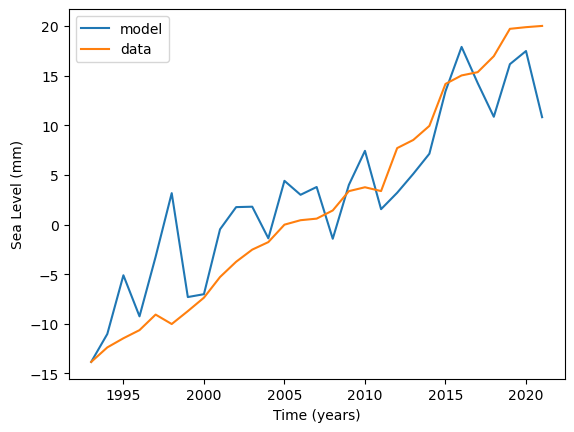

array([1.81727014e+13, 1.60471150e-03, 1.71273437e-01])

In [71]:
# Calculate volume of water on earth
# we need initial volume of oceans
# oceans cover 71% of the Earth's surface
# earth radius = 6371 km

surface_area = lambda r: 4 * np.pi * r**2

area_oceans = 0.71 * surface_area(6371)

average_depth = 3.682
volumne_oceans = area_oceans * average_depth

volumne_oceans, 'm3'

volumne_oceans/1e9, 'billion km3'


def thermal_expansion(T, V_0, alpha, C):
    """
    $$
        dV/dT = alpha * 3 * V_0 *C
    $$
    """
    
    V = np.zeros_like(T)
    V[0] = V_0
    for i in range(1, len(T)):
        V[i] = V[i-1] + alpha * 3 * V[i-1] * C * (T[i] - T[i-1])
    return V

# convert_to_sea_level, by dividing volume by area
def convert_to_sea_level(V, area):
    return V / area

def get_dS(T, V_0, alpha, C):
    V = thermal_expansion(T, V_0, alpha, C)
    S_ = convert_to_sea_level(V, area_oceans)
    return S_-S_[0]+S.values[0]


# try it
V_0 = volumne_oceans
alpha = .01
C = 1.1
S_model = get_dS(T, V_0, alpha, C)

# optimze

# we need to find the best alpha and C
# we will use the least squares method
# we will use the scipy.optimize.curve_fit function

popt, pcov = curve_fit(get_dS, T, S.values, sigma=S_unc.values, absolute_sigma=True, p0=[V_0, alpha, C])
popt

S_opt = get_dS(T, *popt)

plt.plot(S.index, S_opt, label='model')
plt.plot(S.index, S, label='data')
plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.show()
popt

